# [シンプルな音声認識：キーワードの認識]()

In [16]:
import os
import pathlib

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Download dataset

In [4]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
    tf.keras.utils.get_file('mini_speech_commands.zip', origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
                           extract=True, cache_dir='.', cache_subdir='data')
    
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print(commands)

182083584/182082353 [==============================] - 1s 0us/step
['up' 'no' 'right' 'stop' 'go' 'yes' 'left' 'down']


In [8]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)

print(f'num_samples: {num_samples}')
print('Example file tensor:', filenames[0])

train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

num_samples: 8000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/no/f63a6479_nohash_1.wav', shape=(), dtype=string)


In [14]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    # squeeze: removes dimensions of size 1 from the shape of a tensor
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label

AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

# Visualize audio waveform

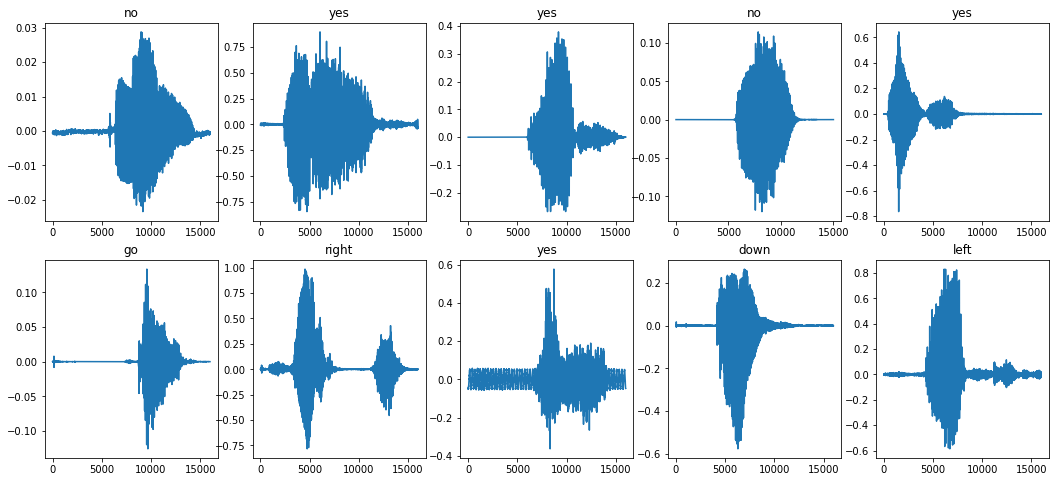

In [26]:
fig = plt.figure(figsize=(18,8))

for i, (audio, label) in enumerate(waveform_ds.take(10)):
    fig.add_subplot(2,5, i+1)
    plt.plot(audio.numpy())
    plt.title(label.numpy().decode('utf-8'))